# Diameter_by_weights_1からの引継ぎ用

自分用に適当にコードを書いているため、説明が分かりにくいかもしれません。質問は
yutaka.higashis3@gmail.comもしくは、yutaka.higashis10@gmail.comまでお願い致します。

①ノートパソコンで作業しており、メモリ容量の関係から、データを使うときは毎回getdfsモジュールからデータをロードし、使用後はdel関数でメモリ消去をしています。高性能なPCで使う分にはdelしなくてもいいかもしれません。

## ライブラリ

In [47]:
import csv
import datetime as dt
import math
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
from matplotlib import animation
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize

#自作モジュール用フォルダにパスを通す
print(os.getcwd())
module_path = os.getcwd()[:-len('notebook')] + 'my_module'
print(module_path)
sys.path.append(module_path)

#自作モジュールと、モジュールアップデート用
#(importlib.reloadをしないとモジュールを書き換えても反映されないため)
import trendline
import dispgraphs
import importlib
import graph_settings
import getdfs

importlib.reload(trendline)
importlib.reload(dispgraphs)
importlib.reload(graph_settings)
importlib.reload(getdfs)



C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone\notebook
C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone\my_module


<module 'getdfs' from 'C:\\Users\\user\\OneDrive - Kyoto University\\shared-Yutaka\\Research\\Hydrophone\\my_module\\getdfs.py'>

## グラフセッティング

In [48]:
graph_settings.setsettings()

## 初期値設定

In [49]:
print(os.getcwd())
PATH_SAVE_GRAPHS = os.getcwd()[:-len('notebook')] + 'graphs_for_seminars/' + '11.14.seminar/'
print(PATH_SAVE_GRAPHS)

C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone\notebook
C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone\graphs_for_seminars/11.14.seminar/


In [50]:
# ハイドロフォン長さ
length_hp_m = 0.275
length_C_m = 0.5
pit_width = 0.2
Dv = 0.0125
Dh = 0.0125

W_IDEAL = np.array([0.15, 0.22, 0.29, 0.65, 0.91, 1.96, 3.01, 6.91, 10.81, 50])*0.001
TARGET_TOT = ['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '25-30mm', '30mm-']


event_marker = ['.', 'x', 'v', '1', 'D']

suffix = ['_Tot(1)', '_Tot(2)', '_Tot(3)', '_Tot(4)', '_Tot(5)',
            '_Tot(6)', '_Tot(7)', '_Tot(8)', '_Tot(9)', '_Tot(10)']

# 直上中央ハイドロフォン
names_of_center = ['hp'+ s for s in suffix]
# 中央ハイドロフォン
names_of_C = ['C'+ s for s in suffix]
# 中央右ハイドロフォン
names_of_RC = ['RC'+ s for s in suffix]
# 中央左ハイドロフォン
names_of_LC = ['LC'+ s for s in suffix]
# 右ハイドロフォン
names_of_R = ['R'+ s for s in suffix]
# 左ハイドロフォン
names_of_L = ['L'+ s for s in suffix]

# 右鉛直ハイドロフォン
names_of_VR = ['VR'+ s for s in suffix]
# 左鉛直ハイドロフォン
names_of_VL = ['VL'+ s for s in suffix]


# Corrected直上中央ハイドロフォン
names_of_center_Corrected = ['Corrected_hp'+ s for s in suffix]
# Corrected中央ハイドロフォン
names_of_C_Corrected = ['Corrected_C'+ s for s in suffix]
# Corrected中央右ハイドロフォン
names_of_RC_Corrected = ['Corrected_RC'+ s for s in suffix]
# Corrected中央左ハイドロフォン
names_of_LC_Corrected = ['Corrected_LC'+ s for s in suffix]
# Corrected右ハイドロフォン
names_of_R_Corrected = ['Corrected_R'+ s for s in suffix]
# Corrected左ハイドロフォン
names_of_L_Corrected = ['Corrected_L'+ s for s in suffix]



# スロットナンバーと倍率を対応させる
amplification_factor = {'Tot(1)': '1024', 'Tot(2)': '512', 'Tot(3)': '256', 'Tot(4)': '128',
                        'Tot(5)': '64', 'Tot(6)': '32', 'Tot(7)': '16', 'Tot(8)': '8',
                        'Tot(9)': '4', 'Tot(10)': '2'}

# データを眺める

In [51]:
#後で使う、カウント用
just_once_count = 0

とりあえず使うデータをここで決定。今回は中央ハイドロフォンと、ピットデータ、水深も入れた。(結局後で水深は使わなかった)

In [52]:
#使うcolumns
if just_once_count == 0:
    cols_use = names_of_center + ['Load_Avg', 'Load_Avg_difference', 'WaterLevel(cm)']
    just_once_count += 1
else:
    print('Passed')

In [53]:
print(cols_use)

['hp_Tot(1)', 'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)', 'hp_Tot(6)', 'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)', 'Load_Avg', 'Load_Avg_difference', 'WaterLevel(cm)']


データインポート。get2017method2cleanedmean_pit_trueとは、2017年のmethod2方式のパルス数(method2)で、明らかなエラーを省いて(cleaned)ピットが200kg以上1000kg以下(pit_true)で、30分平均(mean)されているもの

In [54]:
#ここでのdfは、get2017method2cleanedmean_pit_true
df = getdfs.get2017method2cleanedmean_pit_true()
# df = getdfs.get2018method2cleanedmean_pit_ture()

In [55]:
df = df[cols_use]

ピット内の増減

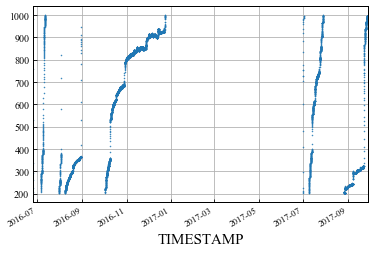

In [56]:
dispgraphs.time_series_graph(df, col_name='Load_Avg')

縦軸にパルス数、横軸に流砂量  
例えば、1024倍の急に折れ曲がって減少している箇所が飽和であると考えられる  
この理論についてはseminear11.14を参照

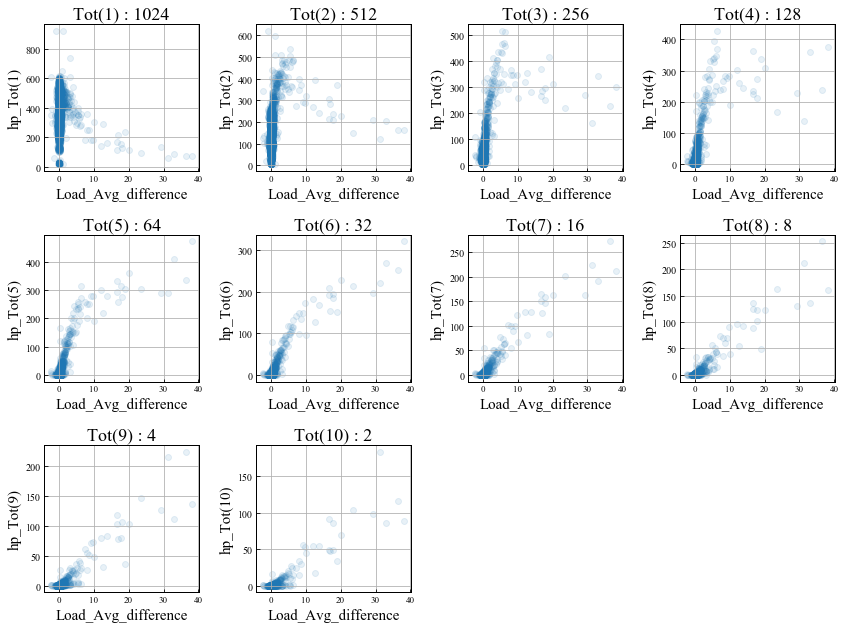

In [57]:
dispgraphs.scatter_graphs(df, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=0.1)

上図から、飽和はLoad_Avg_difference > 0.5で起きていると考えられる(Tot(1)は救いようが無く無視)ので、その時のデータのみを抽出

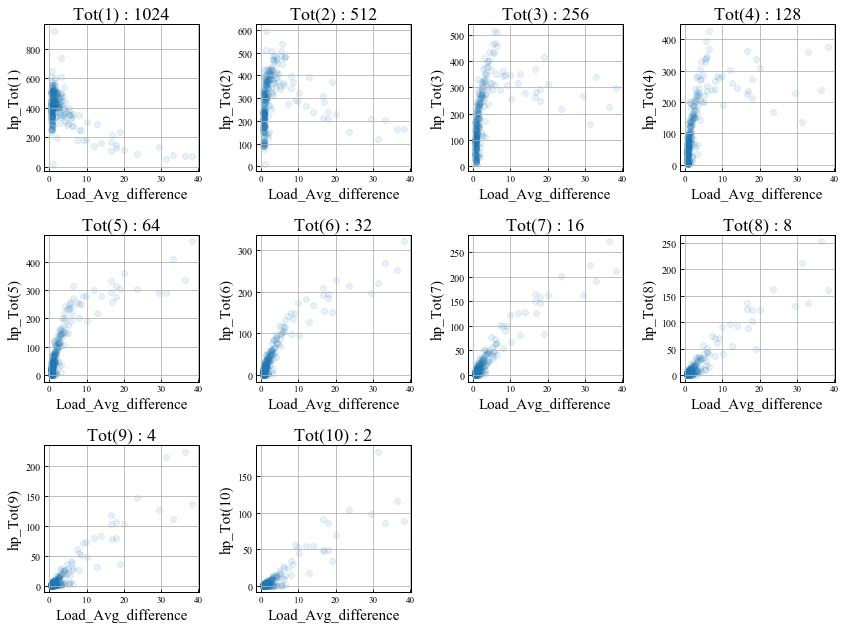

In [58]:
df = df[df['Load_Avg_difference'] > 0.5]
dispgraphs.scatter_graphs(df, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=0.1)

# 低倍率の増加率から判断

In [59]:
#増加量((A - B) / Bで変化率を算出する。)
df_increment = df.pct_change()

# inf を NaNに変換
df_increment.replace([np.inf, -np.inf], np.nan)

len(df_increment) == len(df)

True

In [60]:
#初期値設定、初期化
look = 1
point = look+1
step = 1

オレンジが最初。緑がその次。
このセルを実行するたびに時間がstep分ずれます。
上の初期化セルを実行すると時間が初期化され一番前に戻ります。

[DatetimeIndex(['2016-06-25 04:00:00'], dtype='datetime64[ns]', name='TIMESTAMP', freq=None), Index(['hp_Tot(1)', 'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)',
       'hp_Tot(6)', 'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)',
       'Load_Avg', 'Load_Avg_difference', 'WaterLevel(cm)'],
      dtype='object')]


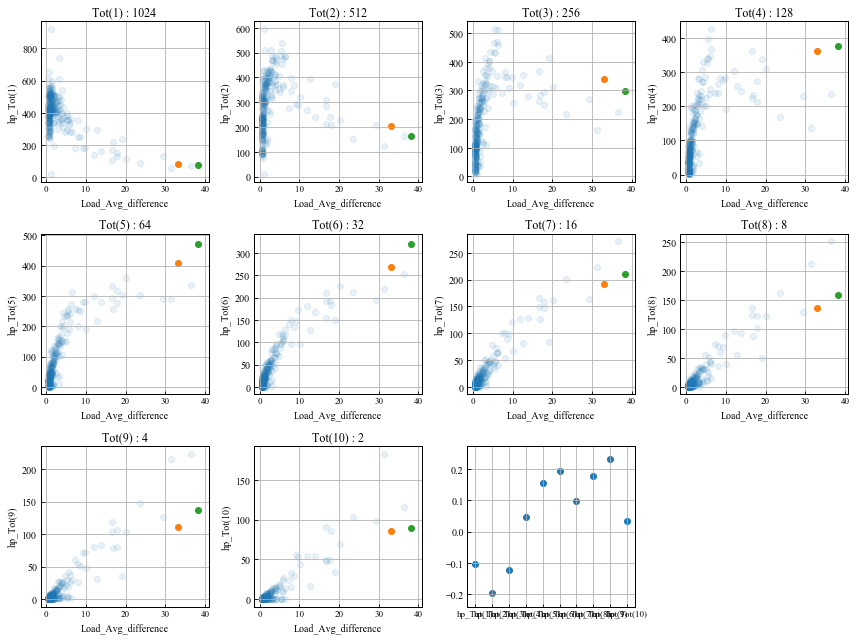

In [95]:
axes = dispgraphs.scatter_graphs(df, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=0.1)
dispgraphs.scatter_graphs(df[point:point+look], list_y_names=names_of_center, 
                          list_x_names=['Load_Avg_difference']*10, figsize=(3*4, 3*3),
                          overlap=True, axes=axes)
dispgraphs.scatter_graphs(df[point+1:point+look+1], list_y_names=names_of_center, 
                          list_x_names=['Load_Avg_difference']*10, figsize=(3*4, 3*3),
                          overlap=True, axes=axes)


ax = plt.subplot(3, 4, 11)
ax.scatter(names_of_center, df_increment[names_of_center][point+1:point+look+1])

print(df[point:point+look].axes)

point += step
# plt.savefig(PATH_SAVE_GRAPHS + '2017_df_2points.jpg')


In [62]:
threshold = 0

In [63]:
# Tot(10)が50以下の時はTot(6)とTot(7)を信頼する
# Tot(10)が50以上の時はTot(9)とTot(10)を信頼する

df_bool_large_tot10 = df_increment[df['hp_Tot(10)'] > 50]
df_large_tot10 = df[df['hp_Tot(10)'] > 50]

df_bool_small_tot10 = df_increment[df['hp_Tot(10)'] <= 50]
df_small_tot10 = df[df['hp_Tot(10)'] <= 50]

In [64]:
print(len(df_bool_large_tot10) + len(df_bool_small_tot10) == len(df))
print(len(df_bool_large_tot10))
print(len(df_bool_small_tot10))
print(len(df_large_tot10) + len(df_small_tot10) == len(df))
print(len(df_large_tot10))
print(len(df_small_tot10))


True
13
253
True
13
253


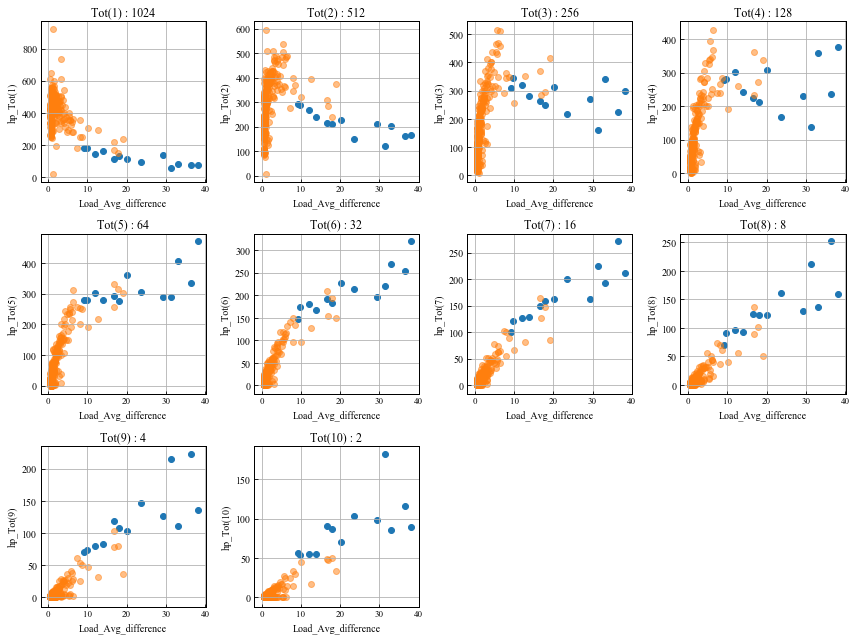

In [65]:
%matplotlib inline
axes = dispgraphs.scatter_graphs(df_large_tot10, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=1)
dispgraphs.scatter_graphs(df_small_tot10, list_y_names=names_of_center, 
                          list_x_names=['Load_Avg_difference']*10, figsize=(3*4, 3*3),
                          overlap=True, axes=axes, alpha=0.5)

In [66]:
#largeの時は判断にTot(10)とTot(9)を使う

df_bool = pd.DataFrame() #最終的に必要なデータのみをTrueとしたboolean

for i in range(len(df_bool_large_tot10)):
    df_now = df_bool_large_tot10[i:i+1]
    sign = float((df_now['hp_Tot(10)']+df_now['hp_Tot(9)'])/2)
    
    if sign > threshold:
        #each_bool : 1 row DataFrame
        each_bool = df_now > threshold 
        df_bool = pd.concat([df_bool, each_bool])
        
    if sign <= threshold:
        each_bool = df_now <= threshold
        df_bool = pd.concat([df_bool, each_bool])

for i in range(len(df_bool_small_tot10)):
    df_now = df_bool_small_tot10[i:i+1]
    sign = float((df_now['hp_Tot(6)']+df_now['hp_Tot(7)'])/2)
    
    if sign > threshold:
        #each_bool : 1 row DataFrame
        each_bool = df_now > threshold
        df_bool = pd.concat([df_bool, each_bool])
        
    elif sign <= threshold:
        each_bool = df_now <= threshold
        df_bool = pd.concat([df_bool, each_bool], sort=False)
        
    else: #sign = nanの時は全てFalse
        df_now.loc[:,:] = [False]*len(df_now.columns)
        df_bool = pd.concat([df_bool, df_now[:]], sort=False)

#時間通りに並び替え
df_bool = df_bool.sort_index()
# print(df_bool)

In [67]:
df_bool

,hp_Tot(1),hp_Tot(2),hp_Tot(3),hp_Tot(4),hp_Tot(5),hp_Tot(6),hp_Tot(7),hp_Tot(8),hp_Tot(9),hp_Tot(10),Load_Avg,Load_Avg_difference,WaterLevel(cm)
TIMESTAMP,,,,,,,,,,,,,
2016-06-25 02:00:00,False,False,False,False,False,False,False,False,False,False,False,False,False
2016-06-25 02:30:00,False,True,True,True,True,True,True,True,True,True,True,True,True
2016-06-25 03:00:00,False,False,False,False,False,True,True,True,True,False,True,True,True
2016-06-25 03:30:00,False,True,True,True,True,True,True,False,True,True,True,True,True
2016-06-25 04:00:00,False,False,False,False,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-23 04:30:00,True,True,True,True,True,True,True,True,True,False,True,False,False
2017-09-23 05:00:00,True,False,True,True,True,True,True,True,True,False,False,True,True
2017-09-23 05:30:00,True,True,True,True,True,True,True,True,False,False,False,False,True


In [69]:
len(df_bool_small_tot10)

253

In [80]:
#左からFalse, False, False...ときてTureになりまたFalseになったときのFalseはTrueに変換
#(つまり、低倍率/7~10チャンネルは常時Trueにする)
colnames = list(df_bool.columns)
df_corrected = pd.DataFrame()
for i in range(len(df_bool)):
    df_row = df_bool[i:i+1]
    
#     now = 
    count_true = 0
    j_hold = 0
    #一列毎に見て、Trueをみつけたらそれよりも右を全部Trueに
    for j, colname in enumerate(colnames):
        if bool(df_row[colname][0]):
            #特に意味は無いが、分かりやすくここで何番目のカラムかを保持
            j_hold = j
            break
            
    #i番目よりも右側のカラム名を取得
    true_colnames = colnames[j_hold:]
    #i番目よりも右側のカラムを全てTrueに
    df_new = df_row[true_colnames].replace(False, True)
    
    df_row.loc[:,j_hold:] = [True]*len(true_colnames)
    df_corrected = df_corrected.append(df[i:i+1][df_row[:]], sort=False)
            

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [81]:
df_corrected

,hp_Tot(1),hp_Tot(2),hp_Tot(3),hp_Tot(4),hp_Tot(5),hp_Tot(6),hp_Tot(7),hp_Tot(8),hp_Tot(9),hp_Tot(10),Load_Avg,Load_Avg_difference,WaterLevel(cm)
TIMESTAMP,,,,,,,,,,,,,
2016-06-25 02:00:00,425.939394,509.696970,412.727273,280.242424,155.878788,53.939394,17.090909,8.969697,8.484848,8.363636,205.4,3.000000,6.709033
2016-06-25 02:30:00,NaN,538.060606,515.878788,395.151515,248.848485,103.030303,45.939394,26.303030,18.424242,10.909091,224.6,5.566667,8.312667
2016-06-25 03:00:00,NaN,NaN,NaN,NaN,NaN,114.181818,63.272727,43.636364,25.939394,8.969697,260.3,5.983333,8.672667
2016-06-25 03:30:00,NaN,486.787879,511.272727,426.666667,313.333333,130.787879,64.848485,40.242424,29.090909,14.060606,292.8,6.383333,8.842667
2016-06-25 04:00:00,NaN,NaN,NaN,NaN,407.757576,268.242424,192.242424,135.515152,110.787879,86.060606,335.0,33.066667,11.646667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-23 04:30:00,450.909091,229.454545,115.878788,63.757576,31.393939,12.606061,4.606061,1.454545,0.242424,0.000000,831.0,0.666667,4.505200
2017-09-23 05:00:00,426.666667,230.060606,113.090909,57.333333,27.515152,9.090909,3.272727,0.848485,0.000000,0.000000,837.0,0.666667,4.502700
2017-09-23 05:30:00,413.212121,209.454545,90.181818,38.060606,21.212121,5.818182,2.545455,0.606061,0.121212,0.000000,841.0,0.833333,4.490367


ある程度上手く飽和中のデータを省くことができている。  
(青：全データ、オレンジ：飽和消去処理後)  
自作モジュールを作ったので  
df_corrected = getdfs.get_nosaturated_df(df)  
で一発変換できる。

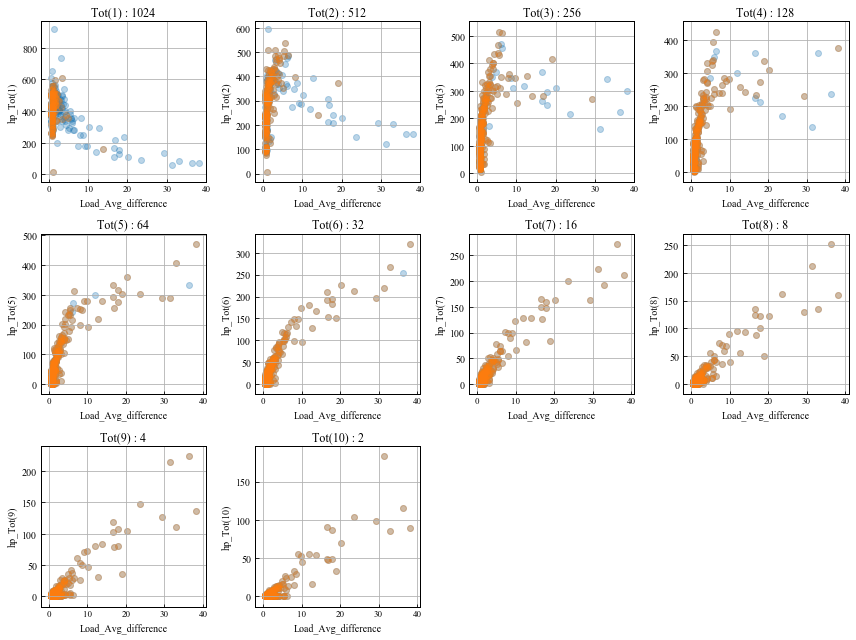

In [82]:
axes = dispgraphs.scatter_graphs(df, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=0.3)

dispgraphs.scatter_graphs(df_corrected, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=0.3, overlap=True, axes=axes)

# df_corrected = getdfs.get_nosaturated_df(df)

In [83]:
df_corrected.head()

,hp_Tot(1),hp_Tot(2),hp_Tot(3),hp_Tot(4),hp_Tot(5),hp_Tot(6),hp_Tot(7),hp_Tot(8),hp_Tot(9),hp_Tot(10),Load_Avg,Load_Avg_difference,WaterLevel(cm)
TIMESTAMP,,,,,,,,,,,,,
2016-06-25 02:00:00,425.939394,509.696970,412.727273,280.242424,155.878788,53.939394,17.090909,8.969697,8.484848,8.363636,205.4,3.000000,6.709033
2016-06-25 02:30:00,NaN,538.060606,515.878788,395.151515,248.848485,103.030303,45.939394,26.303030,18.424242,10.909091,224.6,5.566667,8.312667
2016-06-25 03:00:00,NaN,NaN,NaN,NaN,NaN,114.181818,63.272727,43.636364,25.939394,8.969697,260.3,5.983333,8.672667
2016-06-25 03:30:00,NaN,486.787879,511.272727,426.666667,313.333333,130.787879,64.848485,40.242424,29.090909,14.060606,292.8,6.383333,8.842667
2016-06-25 04:00:00,NaN,NaN,NaN,NaN,407.757576,268.242424,192.242424,135.515152,110.787879,86.060606,335.0,33.066667,11.646667


In [84]:
df_2018 = getdfs.get2018method2cleanedmean_pit_ture()

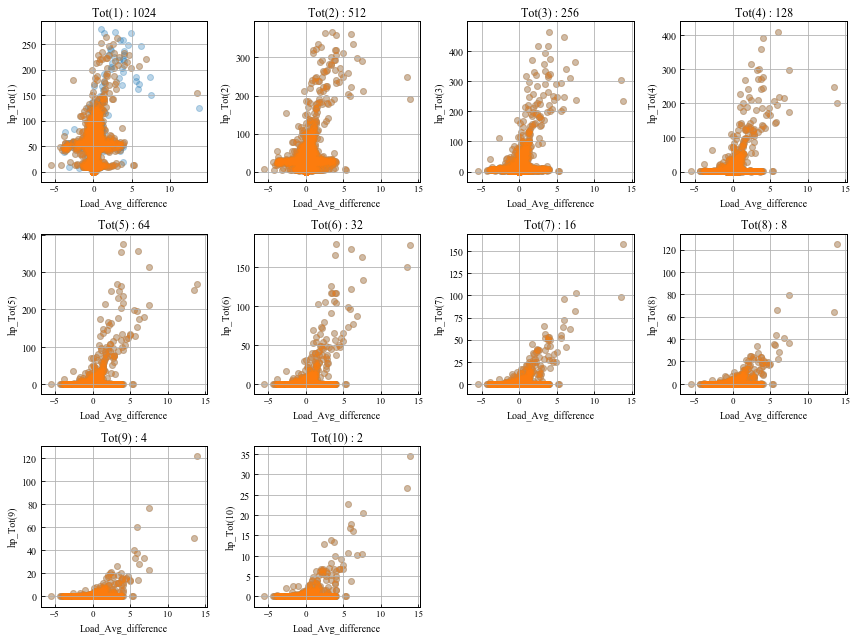

In [85]:
df2018_corrected = getdfs.get_nosaturated_df(df_2018)

In [86]:
list_df2018_3events = getdfs.get2018_3events_method2_mean()
df_2018_3events = pd.DataFrame()
for df_each in list_df2018_3events:
    df_2018_3events = df_2018_3events.append(df_each)

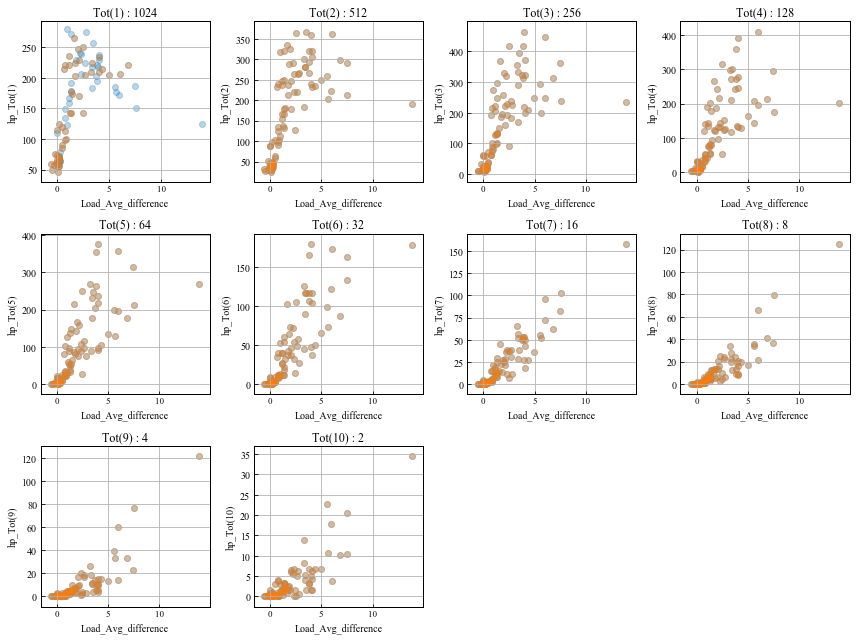

In [87]:
df2018_3events_corrected = getdfs.get_nosaturated_df(df_2018_3events)

# ふるい結果

下のデータフレームは、ピット内のふるい結果である。上から、表面から-30cm、-45cm、-60cmの位置の土砂である。

In [88]:
df_furui = getdfs.get_furui()

In [89]:
x_furui = [1, 2, 5, 7, 9, 15, 31.5, 50] #furui粒径界の上限
x_tot = [2, 5, 6, 7, 8.5, 10, 12.5, 15, 20, 30, 50] #Tot粒径界の上限
g_furui = ['-1mm(g)', '1-2mm(g)', '2-5mm(g)', '5-7mm(g)', '7-9mm(g)', '9-15mm(g)', '19-31.5mm(g)', '31.5mm-(g)']
percent_furui = ['-1mm(%)', '1-2mm(%)', '2-5mm(%)', '5-7mm(%)', '7-9mm(%)', '9-15mm(%)', '19-31.5mm(%)', '31.5mm-(%)']
df_furui

,31.5mm-(g),19-31.5mm(g),9-15mm(g),7-9mm(g),5-7mm(g),2-5mm(g),1-2mm(g),-1mm(g),31.5mm-(%),19-31.5mm(%),9-15mm(%),7-9mm(%),5-7mm(%),2-5mm(%),1-2mm(%),-1mm(%)
TIMESTAMP,,,,,,,,,,,,,,,,
2017-11-23,134,507,1120,804,1557,2718,2163,3079,1.109088,4.196325,9.269988,6.654527,12.886939,22.496275,17.902665,25.484191
2017-11-23,0,61,423,439,1671,4498,3408,2147,0.000000,0.482328,3.344667,3.471179,13.212620,35.565747,26.947102,16.976358
2017-11-23,0,81,697,1091,2481,4775,2073,1296,0.000000,0.648311,5.578678,8.732191,19.857532,38.218345,16.591964,10.372979
2018-04-28,1172,1713,1690,787,1046,2125,2447,3634,8.019707,11.721637,11.564253,5.385247,7.157520,14.540851,16.744218,24.866566
2018-04-28,901,1223,1678,747,1226,2395,2619,3697,6.219798,8.442634,11.583598,5.156703,8.463344,16.533204,18.079525,25.521193
2018-04-28,1267,1086,1981,823,1174,2340,2386,3213,8.878767,7.610371,13.882270,5.767344,8.227050,16.398038,16.720392,22.515767
2018-07-16,387,551,975,372,530,1269,2048,3800,3.896496,5.547725,9.816754,3.745469,5.336287,12.776883,20.620217,38.260169
2018-07-16,458,678,1240,417,560,974,1211,2502,5.696517,8.432836,15.422886,5.186567,6.965174,12.114428,15.062189,31.119403
2018-07-16,866,854,814,409,591,1249,1491,2556,9.807475,9.671574,9.218573,4.631937,6.693092,14.144960,16.885617,28.946772


左図：ピットふるい3日分×3つの位置(-30cm、-45cm、-60cm)＝9データをプロット。粒度分布百分率  
    右図：ピットの下の方と上の方はあまり1イベントを表しているとは言い難い(底には細かいのが多く、上の方は細かいのが流れて大きな流砂が多いなど)ため、真ん中(-45cm)のデータのみを抽出

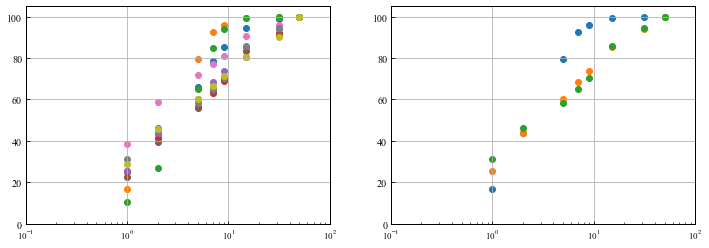

In [90]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1) 

for i in range(9):
    furui_percent_cumsum = np.cumsum(df_furui[i:i+1][percent_furui], axis=1)
    ax1.scatter(x_furui, furui_percent_cumsum)
    ax1.set_xscale('log')
    ax1.set_ylim(0,105)
    ax1.set_xlim((0.1), 100)

ax2 = plt.subplot(1,2,2) 
for i in range(1, 9, 3):
    furui_percent_cumsum = np.cumsum(df_furui[i:i+1][percent_furui], axis=1)
    ax2.scatter(x_furui, furui_percent_cumsum)
    ax2.set_xscale('log')
    ax2.set_ylim(0,105)
    ax2.set_xlim((0.1), 100)

In [91]:
from logging import StreamHandler, DEBUG, Formatter, FileHandler, getLogger

In [92]:
logger = getLogger(__name__)
log_fmt = Formatter('%(asctime)s %(name)s %(lineno)d [%(levelname)s][%(funcName)s] %(message)s ')
handler = StreamHandler()
handler.setLevel('INFO')
handler.setFormatter(log_fmt)
logger.addHandler(handler)

#     handler = FileHandler(DIR + 'train.py.log', 'a')
#     handler.setLevel(DEBUG)
#     handler.setFormatter(log_fmt)
#     logger.setLevel(DEBUG)
#     logger.addHandler(handler)

# 使用メモリ確認

In [93]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
        

|            Variable Name|    Memory|
 ------------------------------------ 
|                       df|     29816|
| df2018_3events_corrected|     77544|
|         df2018_corrected|   6043848|
|                  df_2018|   6043848|
|          df_2018_3events|     77544|
|      df_bool_small_tot10|     28360|
|             df_corrected|     29816|
|                  df_each|     17352|
|             df_increment|     29816|
|           df_small_tot10|     28360|
